In [55]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
ruta_df =  os.path.join("..","..","..", "data", "processed","peleas_ponderadas_dif.parquet")
df = pd.read_parquet(ruta_df)
df

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2000-06-09,Kevin Randleman,Pedro Rizzo,False,0,0.50,0.650000,-1,0,0,...,0.0,0,0.000000,0,1,0,0,-1,0,0
1,2000-09-22,Jeremy Horn,Eugene Jackson,False,0,0.49,0.315789,4,0,0,...,21.0,0,0.000000,0,0,1,0,0,-1,0
2,2001-02-23,Tito Ortiz,Evan Tanner,False,1,-0.22,0.221893,1,0,0,...,0.0,0,0.000000,0,0,0,1,0,0,-1
3,2001-05-04,Chuck Liddell,Kevin Randleman,False,0,0.12,-0.508475,0,0,0,...,4.0,0,0.000000,0,1,0,0,-1,0,0
4,2001-06-29,Pat Miletich,Shonie Carter,False,0,0.08,0.022094,0,0,0,...,-3.0,0,0.000000,0,0,0,1,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508,2025-04-05,Manuel Torres,Drew Dober,False,0,-0.02,0.242133,0,0,132,...,8.0,9,-7.506579,0,0,0,2,1,3,2
3509,2025-04-12,Loma Lookboonmee,Istela Nunes,False,1,-0.05,0.549550,0,-1,73,...,6.0,3,0.000000,0,1,0,1,1,0,0
3510,2025-04-12,Josh Emmett,Lerone Murphy,True,0,-0.26,-0.365385,1,0,191,...,2.0,3,0.000000,0,2,1,0,1,-1,0
3511,2025-04-12,Pat Sabatini,Joanderson Brito,False,0,0.21,-0.048376,2,0,-164,...,0.0,-3,17.914750,3,1,-2,-1,0,0,-1


In [57]:
df["DATE"] = pd.to_datetime(df["DATE"])

# Filtra los combates después del 16 de febrero de 2025
df_antiguos = df[df["DATE"] <= "2025-02-16"]
df_antiguos = df_antiguos[df["DATE"] >= "2010-01-01"]
df_nuevos = df[df["DATE"] > "2025-02-16"]
df_nuevos

C:\Users\mattu\AppData\Local\Temp\ipykernel_549184\177468615.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_antiguos = df_antiguos[df["DATE"] >= "2010-01-01"]


,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
3476,2025-03-01,Andre Fili,Melquizael Costa,True,0,0.31,-0.182708,0,0,235,...,7.0,7,98.186968,11,0,4,5,0,-1,-2
3477,2025-03-01,Brendan Allen,Anthony Hernandez,True,0,0.04,-0.017913,1,1,144,...,4.0,2,15.481054,1,2,3,-3,1,0,-1
3478,2025-03-01,Jean Silva,Melsik Baghdasaryan,False,1,0.02,0.285714,0,0,-80,...,-3.0,3,9.330197,1,2,0,1,0,0,0
3479,2025-03-01,Ricky Simon,Javid Basharat,False,0,-0.01,-0.095434,0,-1,-256,...,8.0,0,2.096952,0,0,0,1,0,0,-1
3480,2025-03-01,Henry Cejudo,Song Yadong,True,-1,-0.81,0.016316,0,0,-7,...,-11.0,-7,-10.532109,0,-2,-4,-1,1,0,-1
3481,2025-03-08,Nasrat Haqparast,Esteban Ribovics,False,0,-0.09,-0.444444,-1,0,-257,...,2.0,-1,18.558209,5,3,-5,1,0,1,-1
3482,2025-03-08,Manel Kape,Asu Almabayev,False,1,0.28,-0.229782,0,0,32,...,11.0,-11,-15.407295,3,-5,-2,-1,-2,0,-1
3483,2025-03-08,Cody Brundage,Julian Marquez,False,1,0.11,0.227273,0,0,1,...,9.0,2,7.747458,2,0,2,1,-1,1,-1
3484,2025-03-08,Andrea Lee,JJ Aldrich,True,0,-0.06,0.196721,0,0,6,...,-2.0,5,12.853855,1,1,1,0,0,0,3
3485,2025-03-08,Ricardo Ramos,Chepe Mariscal,True,0,-0.10,0.082192,1,0,-317,...,-6.0,0,-0.573512,0,-1,2,0,0,-1,0


In [58]:
X_train = df_antiguos.drop(columns=["WINNER", "DATE","Peleador_A","Peleador_B"])
y_train = df_antiguos["WINNER"]
X_test = df_nuevos.drop(columns=["WINNER", "DATE","Peleador_A","Peleador_B"])
y_test = df_nuevos["WINNER"]

In [60]:

params = {'n_estimators': 100, 'max_depth': 39, 'learning_rate': 0.013855267540212752, 'subsample': 0.7097002483532678, 'colsample_bytree': 0.9049166524337446, 'gamma': 0.3376761198544125, 'min_child_weight': 13, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'exact', 'grow_policy': 'lossguide'} 

xgboost_dif = XGBClassifier(**params)

xgboost_dif.fit(X_train, y_train)

y_pred_xgboost_dif = xgboost_dif.predict(X_test)

print("Reporte de clasificación xgboost_dif:")
print(classification_report(y_test, y_pred_xgboost_dif))
print(f'Accuracy: {accuracy_score(y_test, y_pred_xgboost_dif):.4f}')
print(f"F1-score: {f1_score(y_test,y_pred_xgboost_dif)}")

Reporte de clasificación xgboost_dif:
              precision    recall  f1-score   support

       False       0.55      0.48      0.51        23
        True       0.29      0.36      0.32        14

    accuracy                           0.43        37
   macro avg       0.42      0.42      0.42        37
weighted avg       0.45      0.43      0.44        37

Accuracy: 0.4324
F1-score: 0.3225806451612903


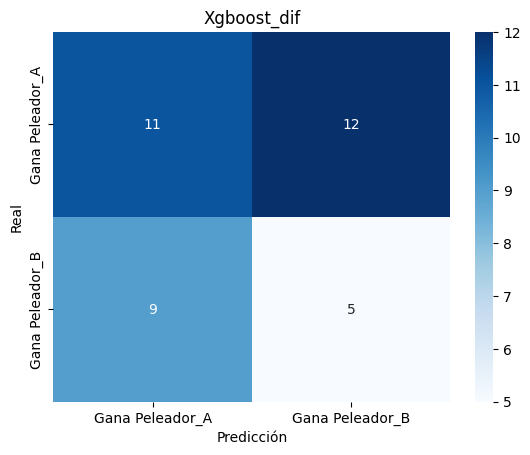

In [61]:
cm = confusion_matrix(y_test, y_pred_xgboost_dif)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], yticklabels=['Gana Peleador_A', 'Gana Peleador_B'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Xgboost_dif')
plt.show()

In [62]:
y_pred_probs = xgboost_dif.predict_proba(X_test)
df_nuevos = df_nuevos.reset_index(drop=True)
# Creamos el DataFrame con los datos
df_resultados = pd.DataFrame({
    'Peleador A': df_nuevos['Peleador_A'].values,
    'Peleador B': df_nuevos['Peleador_B'].values,
    'Ganador': y_test.values,
    'Predicción': y_pred_xgboost_dif,
    'Probabilidad A': y_pred_probs[:, 0],  # Asumiendo clase 1 es A gana
    'Probabilidad B': y_pred_probs[:, 1]   # Asumiendo clase 0 es B gana
})



# Mostrar los primeros resultados
df_resultados

,Peleador A,Peleador B,Ganador,Predicción,Probabilidad A,Probabilidad B
0,Andre Fili,Melquizael Costa,True,1,0.491092,0.508908
1,Brendan Allen,Anthony Hernandez,True,0,0.515982,0.484018
2,Jean Silva,Melsik Baghdasaryan,False,0,0.505479,0.494521
3,Ricky Simon,Javid Basharat,False,0,0.529810,0.470190
4,Henry Cejudo,Song Yadong,True,0,0.551251,0.448749
5,Nasrat Haqparast,Esteban Ribovics,False,0,0.504828,0.495172
6,Manel Kape,Asu Almabayev,False,0,0.570859,0.429141
7,Cody Brundage,Julian Marquez,False,1,0.454534,0.545466
8,Andrea Lee,JJ Aldrich,True,0,0.526626,0.473374
9,Ricardo Ramos,Chepe Mariscal,True,1,0.458780,0.541220


In [63]:
len(df_nuevos), len(df_antiguos), len(df)

(37, 3193, 3513)

In [64]:
y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred_xgboost_dif).reset_index(drop=True)

# Crear un DataFrame con los valores reales y predichos
df_errores = pd.DataFrame({
    'Real': y_test_series,
    'Predicho': y_pred_series
})

# Filtrar los errores
errores = df_errores[df_errores['Real'] != df_errores['Predicho']]

# Mostrarlos
print("Predicciones fallidas:")
print(errores)

Predicciones fallidas:
     Real  Predicho
1    True         0
4    True         0
7   False         1
8    True         0
11  False         1
13   True         0
14   True         0
15   True         0
18  False         1
19  False         1
20   True         0
21   True         0
24  False         1
25  False         1
27  False         1
28  False         1
29  False         1
30  False         1
31   True         0
32  False         1
36  False         1


In [65]:
df_nuevos = df_nuevos.reset_index(drop=True)

# Unir con las predicciones fallidas
errores_completos = df_nuevos.loc[errores.index]
errores_completos['Real'] = errores['Real']
errores_completos['Predicho'] = errores['Predicho']

print("Detalles de los errores:")
print(errores_completos)

Detalles de los errores:
         DATE           Peleador_A                 Peleador_B  WINNER  \
1  2025-03-01        Brendan Allen          Anthony Hernandez    True   
4  2025-03-01         Henry Cejudo                Song Yadong    True   
7  2025-03-08        Cody Brundage             Julian Marquez   False   
8  2025-03-08           Andrea Lee                 JJ Aldrich    True   
11 2025-03-15         Amanda Lemos             Iasmin Lucindo   False   
13 2025-03-15         Jalin Turner         Ignacio Bahamondes    True   
14 2025-03-15         Alex Pereira           Magomed Ankalaev    True   
15 2025-03-22        Josiane Nunes         Priscila Cachoeira    True   
18 2025-03-22  Alexander Hernandez             Kurt Holobaugh   False   
19 2025-03-22       Chidi Njokuani  Elizeu Zaleski dos Santos   False   
20 2025-03-22       Marvin Vettori              Roman Dolidze    True   
21 2025-03-29       Jan Blachowicz              Carlos Ulberg    True   
24 2025-03-29        Marci

In [66]:
# Crear un DataFrame para las importancias de las características
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgboost_dif.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                    Feature  Importance
4                  REV_DIFF    0.045967
2                   TD_DIFF    0.042174
24         Derrotas_KO_DIFF    0.041618
25        Derrotas_Sub_DIFF    0.041396
0                   KD_DIFF    0.040582
11           STR_LEG_A_DIFF    0.038764
16            GRAPPLER_DIFF    0.037825
20               Racha_DIFF    0.037405
18              Peleas_DIFF    0.037372
7          TOTAL_STR_A_DIFF    0.037273
22       Victorias_Sub_DIFF    0.037144
1              SIG_STR_DIFF    0.036918
9           STR_HEAD_A_DIFF    0.036835
13        STR_CLINCH_A_DIFF    0.036604
21        Victorias_KO_DIFF    0.036147
8                 TD_A_DIFF    0.035749
12      STR_DISTANCE_A_DIFF    0.035746
10          STR_BODY_A_DIFF    0.035715
3              SUB_ATT_DIFF    0.035321
19              Puntos_DIFF    0.035299
6              TD_PORC_DIFF    0.035288
5                 CTRL_DIFF    0.034728
17              Record_DIFF    0.034592
15             STRIKER_DIFF    0.034130


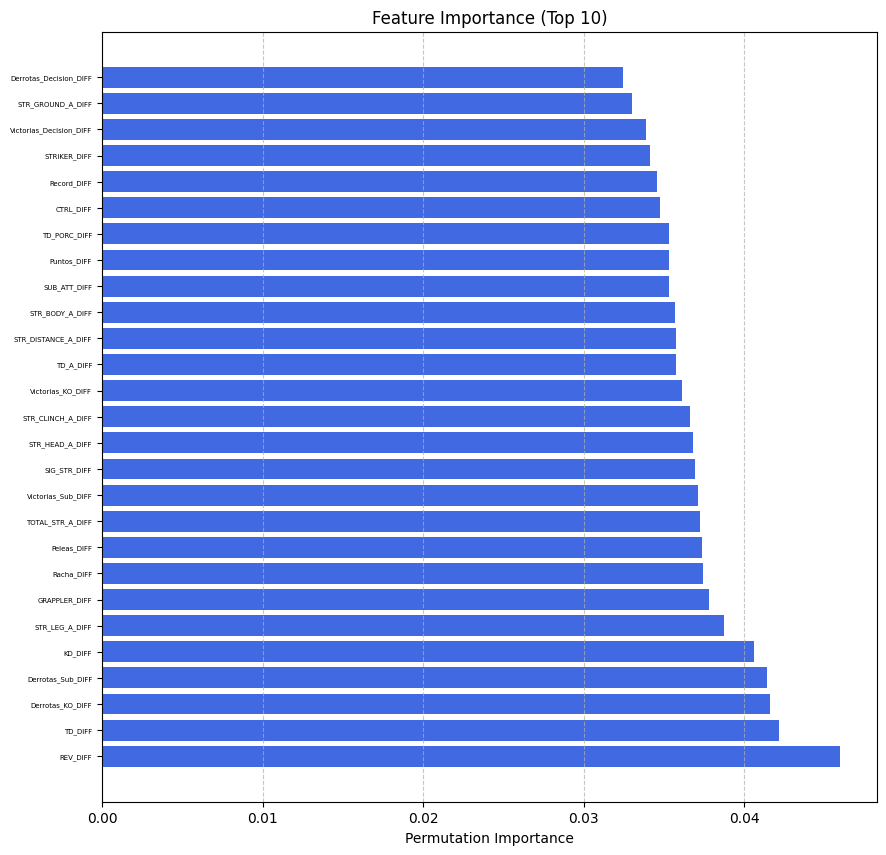

In [67]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()